<a href="https://colab.research.google.com/github/karlmaji/pytorch_learning/blob/master/f_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir img_KL

mkdir: cannot create directory ‘img_KL’: File exists


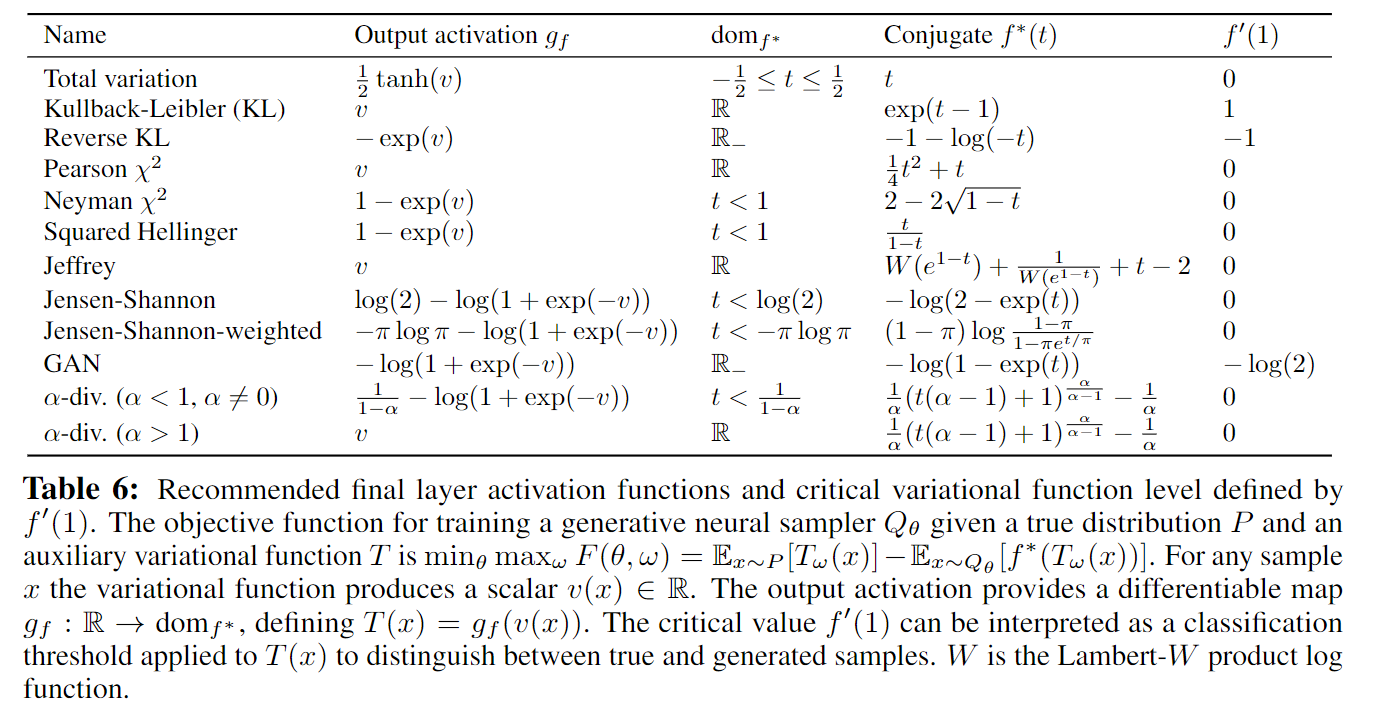

In [ ]:
cd ./img_KL

/content/img_KL


In [ ]:
rm *

In [ ]:
cd ..

/content


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision

batch_size = 128
img_size = torch.as_tensor([1,28,28])
noise_dim = 8

class Reverse_KLf_loss(nn.Module):
  def __init__(self):
    super().__init__()
  def forward(self,x):
    return (-1-torch.log(-x)).mean()
class Reverse_Kl_activation(nn.Module):
  def __init__(self):
    super().__init__()
  def forward(self,x):
    return -torch.exp(x)


class Squared_Hellinger_activation(nn.Module):
  def __init__(self):
    super().__init__()
  def forward(self,x):
    return 1-torch.exp(x)
class Squared_Hellinger_loss(nn.Module):
  def __init__(self):
    super().__init__()
  def forward(self,x):
    return (x/(1-x+1e-5)).mean()


class KL_activation(nn.Module):
  def __init__(self):
    super().__init__()
  def forward(self,x):
    return x
class KL_loss(nn.Module):
  def __init__(self):
    super().__init__()
  def forward(self,x):
    return torch.exp(x-1).mean()

class Generator(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(noise_dim,128),
        nn.BatchNorm1d(128),
        nn.GELU(),
        nn.Linear(128,256),
        nn.BatchNorm1d(256),
        nn.GELU(),
        nn.Linear(256,512),
        nn.BatchNorm1d(512),
        nn.GELU(),
        nn.Linear(512,img_size.prod()),
        nn.Tanh()
    )
  def forward(self,x):
    x = self.model(x)
    return x.reshape(-1,*img_size)
class Discrimnator(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
        nn.Flatten(start_dim=1),
        nn.Linear(img_size.prod(),512),
        nn.GELU(),
        nn.Linear(512,256),
        nn.GELU(),
        nn.Linear(256,128),
        nn.GELU(),
        nn.Linear(128,64),
        nn.GELU(),
        nn.Linear(64,1),
        #nn.Sigmoid()
        KL_activation()
    )
  def forward(self,x):
    x = self.model(x)
    return x
# Training
dataset = torchvision.datasets.MNIST("mnist_data", train=True, download=True,
                                     transform=torchvision.transforms.Compose(
                                         [
                                             torchvision.transforms.Resize(28),
                                             torchvision.transforms.ToTensor(),
                                             torchvision.transforms.Normalize([0.5], [0.5]),
                                         ]
                                                                             )
                                     )
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

generator = Generator()
discrimnator = Discrimnator()

g_opt = torch.optim.Adam(generator.parameters(), lr=0.0003, betas=(0.4, 0.8), weight_decay=0.0001)
d_opt = torch.optim.Adam(discrimnator.parameters(), lr=0.0003, betas=(0.4, 0.8), weight_decay=0.0001)

device = "cuda:0" if torch.cuda.is_available() else "cpu"
epoch = 100

loss_fn = KL_loss().to(device)
generator = generator.to(device)
discrimnator = discrimnator.to(device)

real_loss_log =[]
fake_loss_log =[]
g_loss_log=[]
d_loss_log=[]

for i in range(epoch):
  for idx,(real_img,_) in enumerate(dataloader):
    noise = torch.randn(batch_size,noise_dim,device=device)
    fake_img = generator(noise)
    # train generator
    g_loss = -discrimnator(fake_img).mean()
    g_opt.zero_grad()
    g_loss.backward()
    g_opt.step()

    # train discrimnator
    real_img = real_img.to(device)
    fake_loss = loss_fn(discrimnator(fake_img.detach()))
    real_loss = (discrimnator(real_img)).mean()
    d_loss = fake_loss - real_loss
    d_opt.zero_grad()
    d_loss.backward()
    d_opt.step()


    real_loss_log.append(real_loss.item())
    fake_loss_log.append(fake_loss.item())
    d_loss_log.append(d_loss.item())
    g_loss_log.append(g_loss.item())

    # 观察real_loss与fake_loss，同时下降同时达到最小值，并且差不多大，说明D已经稳定了

    if idx % 50 == 0:
        print(f"step:{len(dataloader)*i+idx}, g_loss:{g_loss.item()}, d_loss:{d_loss.item()},real_loss:{real_loss.item()},fake_loss:{fake_loss.item()}")

    if idx % 5000 == 0:
        image = fake_img[:16].data
        torchvision.utils.save_image(image, f"./img_KL/image_{len(dataloader)*i+i}.png", nrow=4)




step:0, g_loss:-0.047939613461494446, d_loss:0.3390847444534302,real_loss:0.04686048626899719,fake_loss:0.38594523072242737
step:50, g_loss:-1.15879487991333, d_loss:0.17534244060516357,real_loss:1.0182937383651733,fake_loss:1.193636178970337
step:100, g_loss:-0.9509037733078003, d_loss:-0.0017855167388916016,real_loss:0.9782358407974243,fake_loss:0.9764503240585327
step:150, g_loss:-1.0582256317138672, d_loss:-0.2922682762145996,real_loss:1.3720287084579468,fake_loss:1.0797604322433472
step:200, g_loss:0.7848707437515259, d_loss:-0.10133373737335205,real_loss:0.27378714084625244,fake_loss:0.1724534034729004
step:250, g_loss:0.583507776260376, d_loss:0.6510087251663208,real_loss:-0.44248053431510925,fake_loss:0.20852816104888916
step:300, g_loss:-0.6679407358169556, d_loss:-0.24348938465118408,real_loss:1.0027620792388916,fake_loss:0.7592726945877075
step:350, g_loss:-0.6158080101013184, d_loss:-0.19540083408355713,real_loss:0.9256006479263306,fake_loss:0.7301998138427734
step:400, g_l

TypeError: ignored

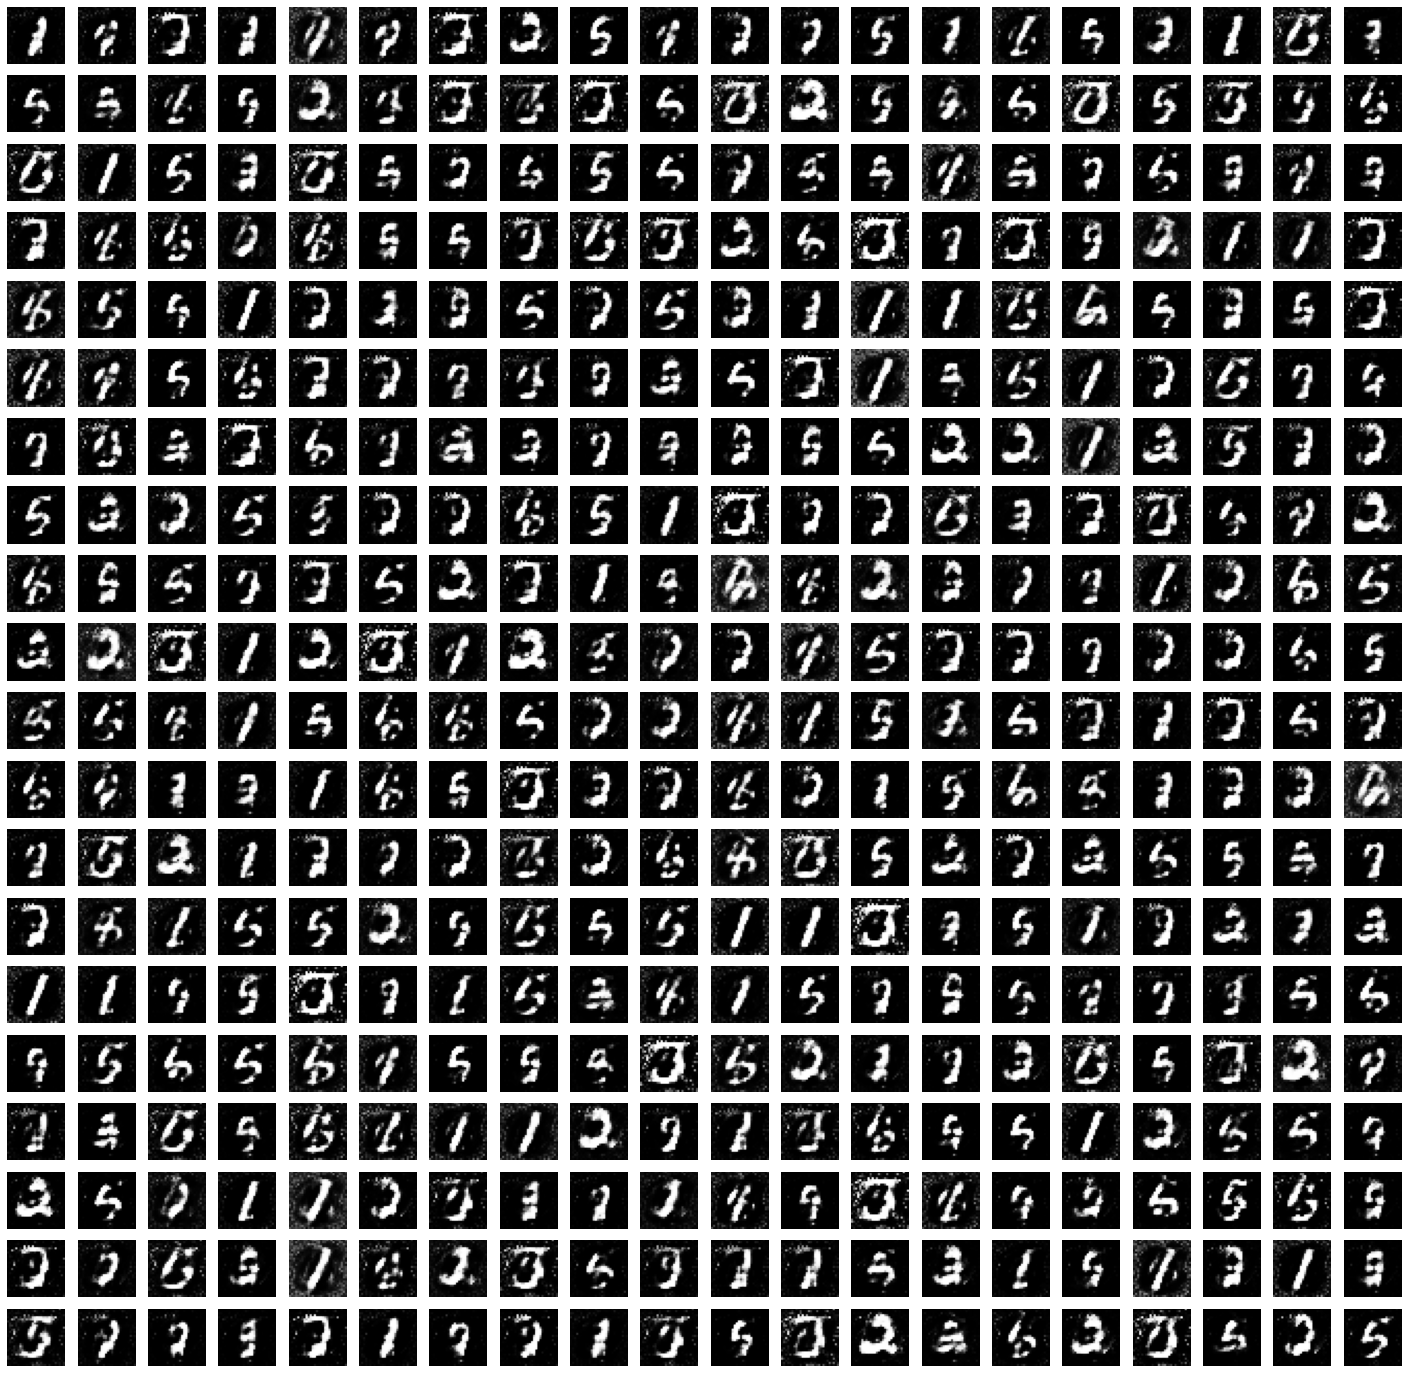

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
n = 20
digit_size = 28

noise = torch.randn(n*n,noise_dim,device=device)

generator.eval()
plt.figure(figsize=(25,25))
with torch.no_grad():
    pre_img = generator(noise).detach().cpu()
    for index in range(pre_img.size(0)):
      digit = pre_img[index].view((digit_size, digit_size))
      plt.subplot(n,n,index+1)
      plt.imshow(digit,cmap="Greys_r")
      plt.xticks([])
      plt.yticks([])
      plt.axis('off');

plt.show()

In [ ]:
import numpy as np
from scipy.stats import norm
model = generator
n = 20
digit_size = 28

grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
noise_else_dim = np.random.normal(0,1,(1,8))

(-0.5, 559.5, 559.5, -0.5)

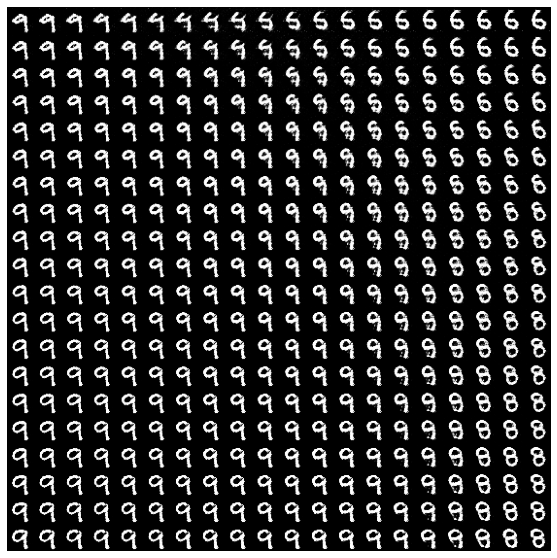

In [ ]:
import numpy as np
from scipy.stats import norm

n = 20
digit_size = 28

grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
noise_else_dim = np.random.normal(0,1,(1,8))
generator = generator.to(device)
generator.eval()
figure = np.zeros((digit_size * n, digit_size * n))
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z = noise_else_dim.copy()
        z[0,0]= xi
        z[0,1]= yi
        z_sampled = torch.as_tensor(z,dtype=torch.float,device=device)
        with torch.no_grad():
            decode = generator(z_sampled).detach().cpu()
            digit = decode.view((digit_size, digit_size))
            figure[
                i * digit_size: (i + 1) * digit_size,
                j * digit_size: (j + 1) * digit_size
            ] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap="Greys_r")
plt.xticks([])
plt.yticks([])
plt.axis('off')